In [9]:
# Third-party
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.special import logsumexp
from scipy.optimize import minimize

from pyia import GaiaData
from gala.mpl_style import laguna, hesperia

In [2]:
gc_frame = coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc)

In [3]:
hex_h = 200
filename = 'rv-good-plx.fits'
g = GaiaData(filename)

c = g.skycoord
galcen = c.transform_to(gc_frame)

In [4]:
gal = c.galactic
gal.set_representation_cls('cartesian')

In [5]:
cyl = gal.transform_to(gc_frame)
cyl.set_representation_cls('cylindrical')

xyz = np.vstack((gal.u.to(u.pc).value, 
                 gal.v.to(u.pc).value,
                 gal.w.to(u.pc).value)).T

UVW = np.vstack((gal.U.to(u.km/u.s).value, 
                 gal.V.to(u.km/u.s).value, 
                 gal.W.to(u.km/u.s).value)).T

# UVW = np.vstack((cyl.d_rho.to(u.km/u.s).value, 
#                  - ((cyl.rho * cyl.d_phi).to(u.km/u.s, u.dimensionless_angles()).value + 220.), 
#                  cyl.d_z.to(u.km/u.s).value)).T

disk_vmask = np.linalg.norm(UVW, axis=1) < 120
# xyz = xyz[disk_vmask]
# UVW = UVW[disk_vmask]

---

## Hexagons

In [6]:
def get_hexagons(h):
    a = np.sqrt(3)/2 * h # inner side
    
    pas = dict() # keyed by "ring"
    pas[0] = list()
    pas[1] = list()
    
    pa0 = mpl.patches.RegularPolygon((0., 0.), numVertices=6, 
                                     radius=h, orientation=np.pi/2)
    pas[0].append(pa0.get_verts())

    for ang in np.arange(0, 360, 60)*u.deg:
        # Ring 1
        xy0 = 2*a * np.array([np.cos(ang+90*u.deg), np.sin(ang+90*u.deg)])
        pa = mpl.patches.RegularPolygon(xy0, numVertices=6, 
                                        radius=h, orientation=np.pi/2)
        pas[1].append(pa.get_verts())
        
    return pas

In [7]:
hexs = get_hexagons(hex_h)

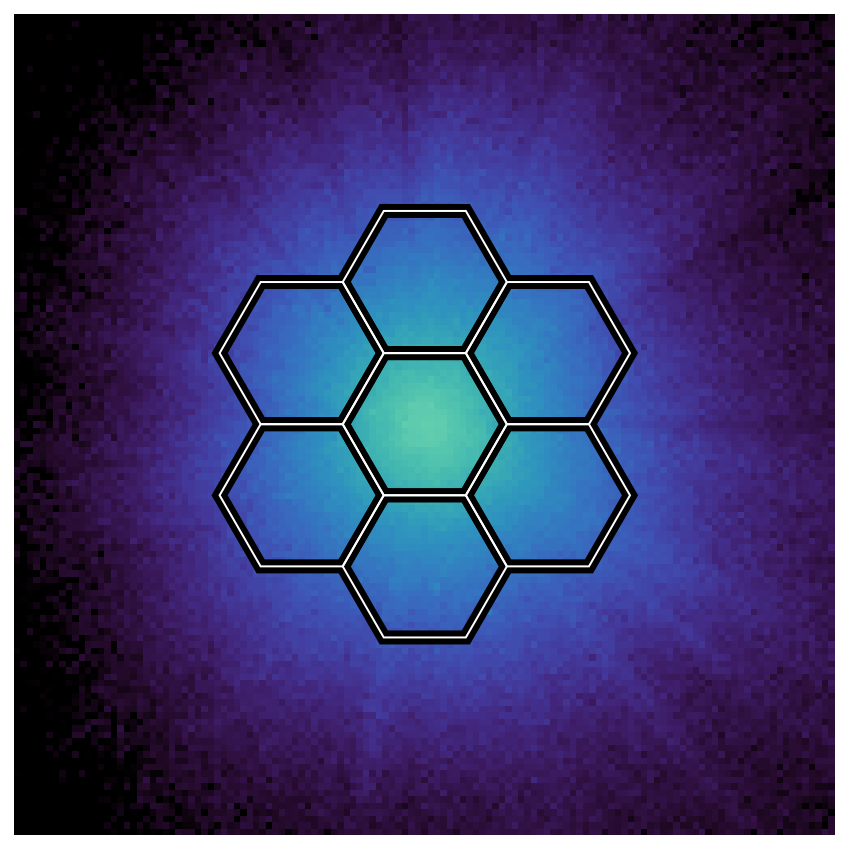

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for k in hexs.keys():
    for pa in hexs[k]:
        pat = mpl.patches.Polygon(pa, facecolor='none', 
                                  edgecolor='w', linewidth=1, 
                                  zorder=100)
        ax.add_patch(pat)
        
        pat = mpl.patches.Polygon(pa, facecolor='none', 
                                 edgecolor='k', linewidth=7, 
                                 zorder=99)
        ax.add_patch(pat)

# ax.plot(gal.u, gal.v, 
#         marker=',', alpha=0.1, color='k',
#         linestyle='none', zorder=10)
H, xe, ye = np.histogram2d(gal.u.to_value(u.pc), gal.v.to_value(u.pc),
                           bins=np.linspace(-1000, 1000, 128))
ax.pcolormesh(xe, ye, H.T,
              norm=mpl.colors.LogNorm(vmin=4e1, vmax=6e3),
              cmap=laguna) 
        
lim = 1000
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$y$ [pc]')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for k in ax.spines:
    ax.spines[k].set_visible(False)

fig.tight_layout()
# fig.savefig('../../ths.png', dpi=250)

---

In [9]:
# vmax = 1400
# for k in hexs.keys():
#     for b, pa in enumerate(hexs[k]):
#         hex_mask = mpl.patches.Path(pa).contains_points(xyz[:, :2])
#         print(hex_mask.sum())

#         lim = 150
#         bins = np.linspace(-lim, lim, 101)

#         fig, axes = plt.subplots(2, 2, figsize=(8, 7.2))
        
#         for a, (i, j) in zip([0, 2, 3], [(0, 1), (0, 2), (1, 2)]):
#             ax = axes.flat[a]
#             H, xe, ye = np.histogram2d(UVW[hex_mask,i], UVW[hex_mask,j], bins=bins)
#             ax.pcolormesh(xe, ye, H.T, 
#                           norm=mpl.colors.LogNorm(), 
#                           cmap='magma', vmin=1, vmax=vmax)
#             ax.set_xlim(-lim, lim)
#             ax.set_ylim(-lim, lim)
        
#         axes[0, 0].set_ylabel('$-v_y-220$')
#         axes[1, 0].set_ylabel('$v_z$')
#         axes[1, 0].set_xlabel('$v_x$')
#         axes[1, 1].set_xlabel('$-v_y-220$')
#         axes[0, 0].xaxis.set_ticklabels([])
#         axes[1, 1].yaxis.set_ticklabels([])
        
#         # axes[0,1].set_visible(False)
#         ax = axes[0,1]
#         for k_ in hexs.keys():
#             for pa_ in hexs[k_]:
#                 pa_ = mpl.patches.Polygon(pa_, facecolor='none', edgecolor='#333333')
#                 ax.add_patch(pa_)
                
#         ax.add_patch(mpl.patches.Polygon(pa, facecolor='#333333', edgecolor='#333333'))
#         ax.set_xlim(-750, 750)
#         ax.set_ylim(-750, 750)
#         ax.set_xlabel('$x$ [pc]')
#         ax.set_ylabel('$y$ [pc]')

#         fig.tight_layout()
#         fig.savefig('../plots/uvw/big-hex-{2}-{0}-{1:02d}.png'.format(k, b, 'all'), dpi=250)
#         plt.close(fig)

In [11]:
_cyl = gal.represent_as('cylindrical')
mask_r100 = (_cyl.rho < 100*u.pc) & (np.abs(_cyl.z) < 250*u.pc)
mask_r300 = (_cyl.rho < 300*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r100.sum(), mask_r500.sum()

(165043, 1880612)

In [12]:
def kde_obj(V, V_local, bw):
    """Note: this is barely tested...by eye
    
    V : (n, 3)
    V_local : (m, 3)
    """
    delta = V[None] - V_local[:, None] # (m, n, 3)
    
    # objective function
    arg = np.sum(-0.5 * (delta / bw)**2, axis=-1) # (m, n)
    scalar = logsumexp(arg, axis=0).sum()
    
    # gradient 
    _arg = arg - arg.max(axis=0)[None] # (m, n)
    grad = np.sum(-delta / bw**2 * np.exp(_arg)[..., None], axis=0) / np.sum(np.exp(_arg), axis=0)[..., None]
    
    return scalar, grad

In [13]:
local_v = UVW[disk_vmask & mask_r100][::24]
local_x = xyz[disk_vmask & mask_r100][::24]

train_v = UVW[disk_vmask & mask_r300][::128]
train_x = xyz[disk_vmask & mask_r300][::128]

test_v = UVW[disk_vmask & mask_r300]
test_x = xyz[disk_vmask & mask_r300]

local_v.shape, train_v.shape, test_v.shape

((6716, 3), (8135, 3), (1041234, 3))

In [14]:
# _s, _g = kde_obj(test_v, control_v, bw=5.)

In [15]:
# test_v2 = test_v.copy()
# fudge = .7
# test_v2[612, 1] += fudge

# _s2, _g2 = kde_obj(test_v2, anchor_v, bw=5.)

In [16]:
# (_s2 - _s) / fudge # check numerical derivative

In [17]:
# _g[612, 1]

In [18]:
def f_and_grad(p, V_train, X_train, V_local, bw):
    aij = np.array(p[:9]).reshape(3, 3)
    bij = np.array(p[9:]).reshape(9, 3)
    
    VX_train = (V_train[:, None] * X_train[..., None]).reshape(-1, 9)
    s, g = kde_obj(V_train + X_train.dot(aij) + VX_train.dot(bij), 
                   V_local, bw)
    
    grad = np.concatenate(((g[:, None] *  X_train[:, :, None]).sum(axis=0).reshape((9,)), 
                           (g[:, None] * VX_train[:, :, None]).sum(axis=0).reshape((27,))))
    
    return -s, -grad

In [19]:
# p = 1e-3 * np.random.random(size=9)
p = 1e-3 * np.random.random(size=9+27)
_s, _g = f_and_grad(p, train_v, train_x, local_v, bw=5.)

In [20]:
p2 = p.copy()
p2[17] += 1e-8
_s2, __ = f_and_grad(p2, train_v, train_x, local_v, bw=5.)

In [21]:
assert np.allclose((_s2 - _s) / 1e-8,
                   _g[17], rtol=1e-3)

In [22]:
%%time
# res = minimize(f_and_grad, x0=np.zeros(9), 
res = minimize(f_and_grad, x0=np.zeros(9+27), 
               method='L-BFGS-B', jac=True, 
               args=(train_v, train_x, local_v, 3.))

CPU times: user 2h 38min 39s, sys: 15min 13s, total: 2h 53min 53s
Wall time: 24min 45s


In [24]:
res

      fun: -7592.917892088222
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.45550167e+01, -3.00932058e+01,  2.10182695e+01, -1.56383086e+01,
        1.29763272e+01,  4.54636587e+01, -1.46748294e+01,  3.37080678e+01,
       -3.65849995e+01, -8.33931134e+00, -2.32066759e+01,  5.56717656e-02,
       -7.66577359e-01, -3.47298253e+00,  1.77715359e+00,  1.21363324e+01,
       -1.08674231e+01, -5.03825524e+00, -4.12049502e+01,  1.58062903e+01,
       -1.94017215e+01,  1.20632803e+01,  2.72012565e+01, -1.83575803e+01,
        1.47140680e+00, -1.36008728e+01,  2.89632727e+01, -4.47539615e+00,
        1.02172365e+02, -3.11976150e+01,  1.48707407e+01, -4.43503559e+00,
       -1.03516706e+01,  8.45784799e+00,  3.59820529e+00, -1.23820101e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 303
      nit: 285
   status: 0
  success: True
        x: array([-3.96067618e-03, -1.68860003e-02,  1.12224447e-03, -2.62778977e-02,
       -6.29910977

In [25]:
def get_dv(v, x, p):
    return ((x.dot(np.array(p[:9]).reshape(3, 3)) + 
            (v[:, None] * x[..., None]).reshape(-1, 9).dot(np.array(p[9:]).reshape(9, 3))))

def get_pred(v, x, p):
    return v + get_dv(v, x, p)

In [26]:
# OLD:
# # pred_v = (test_v + test_x.dot(np.array(res.x[:9]).reshape(3, 3)) + 
# #           (test_v[:, None] * test_x[..., None]).reshape(-1, 9).dot(np.array(res.x[9:]).reshape(9, 3)))
# pred_v = get_pred(train_v, train_x, res.x)
# pred_v.shape

In [27]:
test_v_pred = get_pred(test_v, test_x, res.x)

(-125, 125)

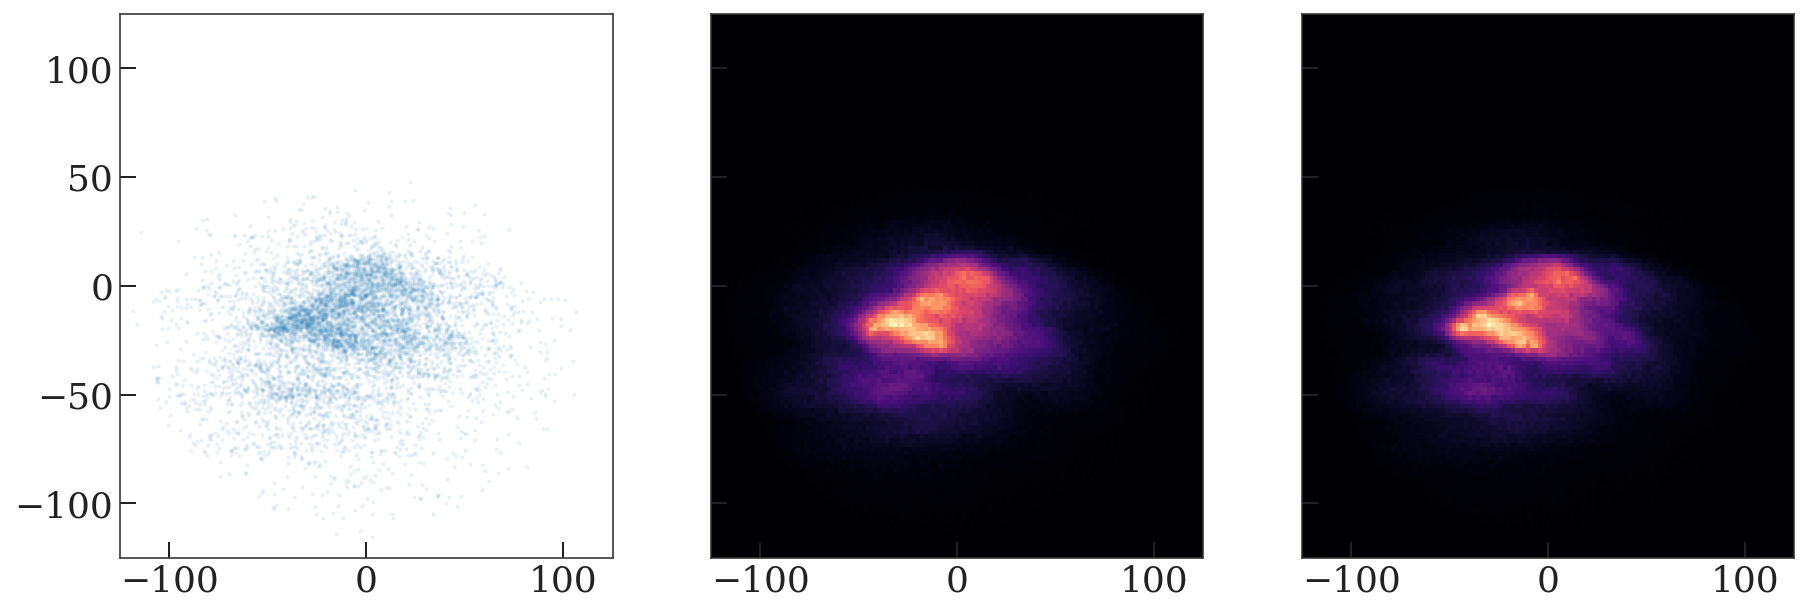

In [28]:
style = dict(marker='o', alpha=0.1, ms=2, ls='none', mew=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         sharex=True, sharey=True)

axes[0].plot(local_v[:, 0], local_v[:, 1], **style)

bins = np.linspace(-125, 125, 128)
axes[1].hist2d(test_v[:, 0], test_v[:, 1], 
               bins=bins)
axes[2].hist2d(test_v_pred[:, 0], test_v_pred[:, 1], 
               bins=bins)

axes[0].set_xlim(-125, 125)
axes[0].set_ylim(-125, 125)

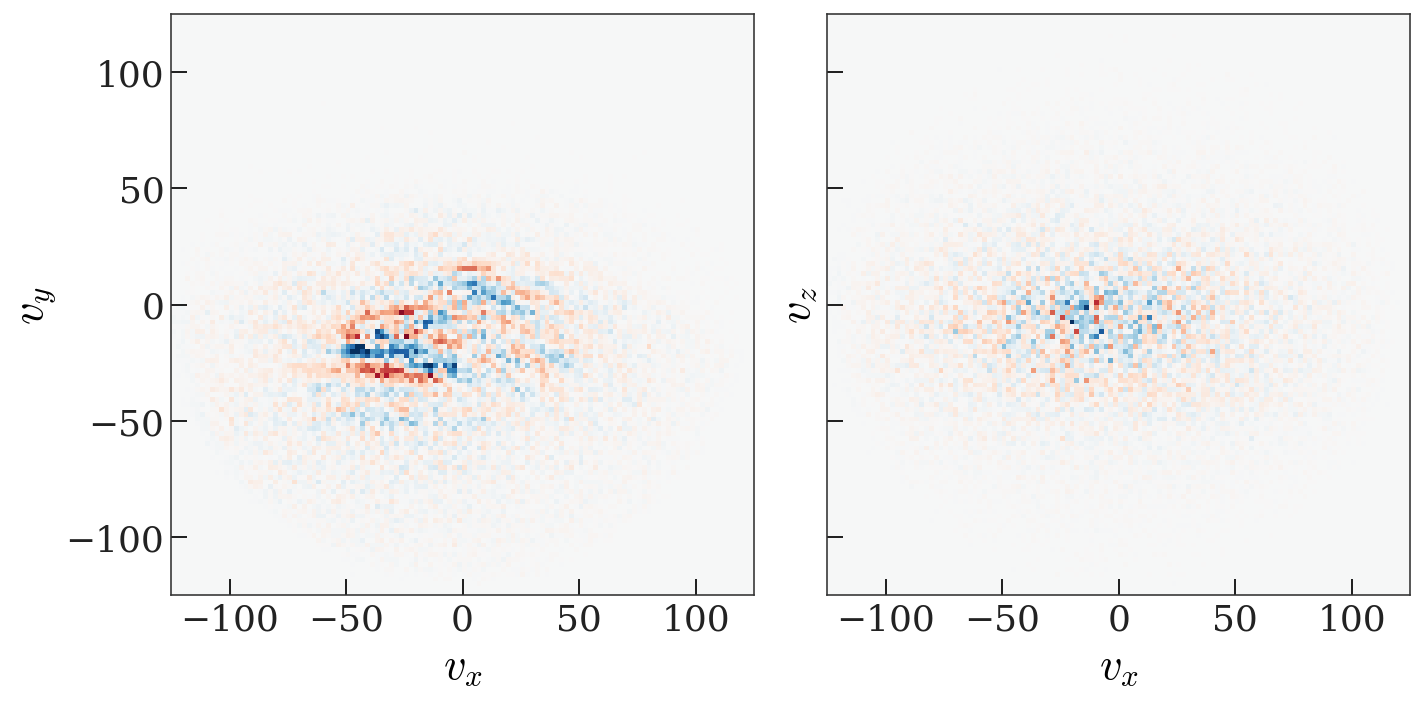

In [29]:
bins = np.linspace(-125, 125, 121)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
H_test, xe, ye = np.histogram2d(test_v[:, 0], test_v[:, 1], bins=bins)
H_pred, xe, ye = np.histogram2d(test_v_pred[:, 0], test_v_pred[:, 1], bins=bins)
cc = ax.pcolormesh(xe, ye, (H_pred - H_test).T,
                   cmap='RdBu', vmin=-200, vmax=200)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')


ax = axes[1]
H_test, xe, ye = np.histogram2d(test_v[:, 0], test_v[:, 2], bins=bins)
H_pred, xe, ye = np.histogram2d(test_v_pred[:, 0], test_v_pred[:, 2], bins=bins)
cc = ax.pcolormesh(xe, ye, (H_pred - H_test).T,
                   cmap='RdBu', vmin=-200, vmax=200)

ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_z$')

# fig.colorbar(cc)
fig.tight_layout()

### Refine training set:

Now we predict on the full training set to see which stars are pulled the least - this will help us define an even better local sample:

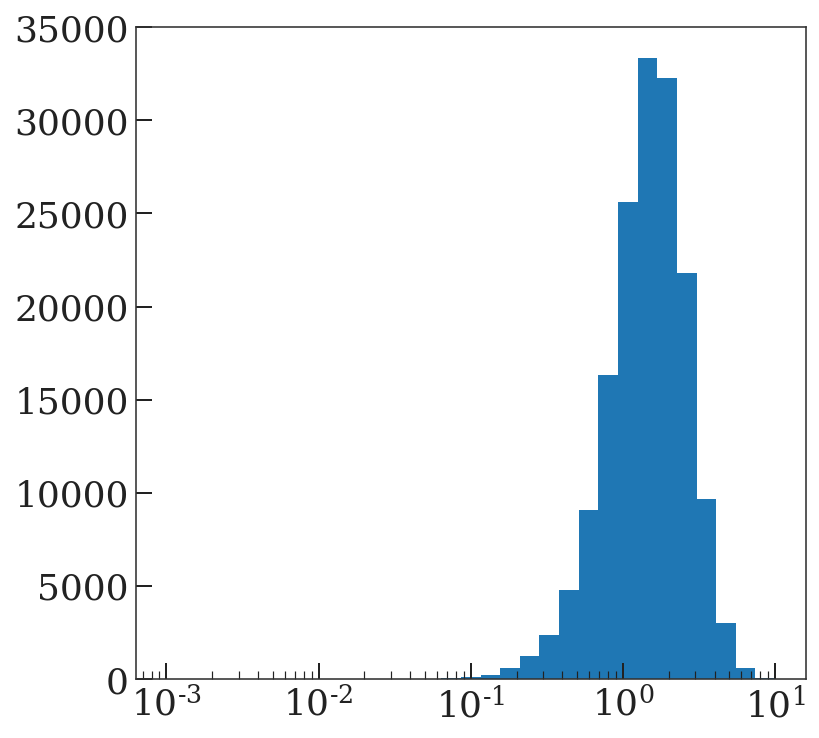

In [32]:
dv = get_dv(UVW[disk_vmask & mask_r100], 
            xyz[disk_vmask & mask_r100], 
            res.x)
dv_mag = np.linalg.norm(dv, axis=1)

plt.hist(dv_mag, bins=np.logspace(-3, 1, 32));
plt.xscale('log')

In [33]:
new_local_v = UVW[disk_vmask & mask_r100][dv_mag < 1][::4]

In [34]:
%%time
new_res = minimize(f_and_grad, x0=np.zeros(9+27), 
                   method='L-BFGS-B', jac=True, 
                   args=(train_v, train_x, new_local_v, 3.))

CPU times: user 4h 1min 3s, sys: 26min 2s, total: 4h 27min 6s
Wall time: 48min 21s


In [35]:
# dv = _v.dot(res.x.reshape(3, 3))

dvmag = np.linalg.norm(dv, axis=-1)
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.scatter(_v_adj[:, 0], _v_adj[:, 1], 
#            # c=dv[:, 1], 
#            c=dvmag,
#            cmap='viridis', vmin=0, vmax=10,
#            marker='.', linewidth=0, alpha=0.2)

In [55]:
vmax = 1400
for name in ['data', 'adjusted']:
    for k in hexs.keys():
        for b, pa in enumerate(hexs[k]):
            hex_mask = mpl.patches.Path(pa).contains_points(xyz[:, :2])
            print(hex_mask.sum())

            this_x = xyz[disk_vmask & hex_mask]
            this_v = UVW[disk_vmask & hex_mask]
            if name == 'adjusted':
                # fix_v = this_v + this_x.dot(res.x.reshape(3, 3))
                fix_v = get_pred(this_v, this_x, res.x)
                the_v = fix_v
            else:
                the_v = this_v

            lim = 150
            bins = np.linspace(-lim, lim, 101)

            fig, axes = plt.subplots(2, 2, figsize=(8, 7.2))

            for a, (i, j) in zip([0, 2, 3], [(0, 1), (0, 2), (1, 2)]):
                ax = axes.flat[a]
                H, xe, ye = np.histogram2d(the_v[:,i], the_v[:,j], bins=bins)
                ax.pcolormesh(xe, ye, H.T, 
                              norm=mpl.colors.LogNorm(), 
                              cmap='magma', vmin=1, vmax=vmax)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            axes[0, 0].set_ylabel('$-v_y-220$')
            axes[1, 0].set_ylabel('$v_z$')
            axes[1, 0].set_xlabel('$v_x$')
            axes[1, 1].set_xlabel('$-v_y-220$')
            axes[0, 0].xaxis.set_ticklabels([])
            axes[1, 1].yaxis.set_ticklabels([])

            # axes[0,1].set_visible(False)
            ax = axes[0,1]
            for k_ in hexs.keys():
                for pa_ in hexs[k_]:
                    pa_ = mpl.patches.Polygon(pa_, facecolor='none', edgecolor='#333333')
                    ax.add_patch(pa_)

            ax.add_patch(mpl.patches.Polygon(pa, facecolor='#333333', edgecolor='#333333'))
            ax.set_xlim(-750, 750)
            ax.set_ylim(-750, 750)
            ax.set_xlabel('$x$ [pc]')
            ax.set_ylabel('$y$ [pc]')

            fig.tight_layout()
            fig.savefig('bighex-{2}-{0}-{1:02d}.png'.format(k, b, name), dpi=250)
            plt.close(fig)

522716
237167
198882
198682
222218
238955
222799
522716
237167
198882
198682
222218
238955
222799


```
convert -delay 30 -loop 1 bighex-data-1-*.png bighex-data-ring.gif
convert -delay 30 -loop 1 bighex-adjusted-1-*.png bighex-adjusted-ring.gif
```

In [36]:
UVW_fix = get_pred(UVW, xyz, new_res.x)

In [37]:
R_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 750.) & (np.abs(xyz[:, 2]) < 500)
close_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 150.) & (np.abs(xyz[:, 2]) < 200)

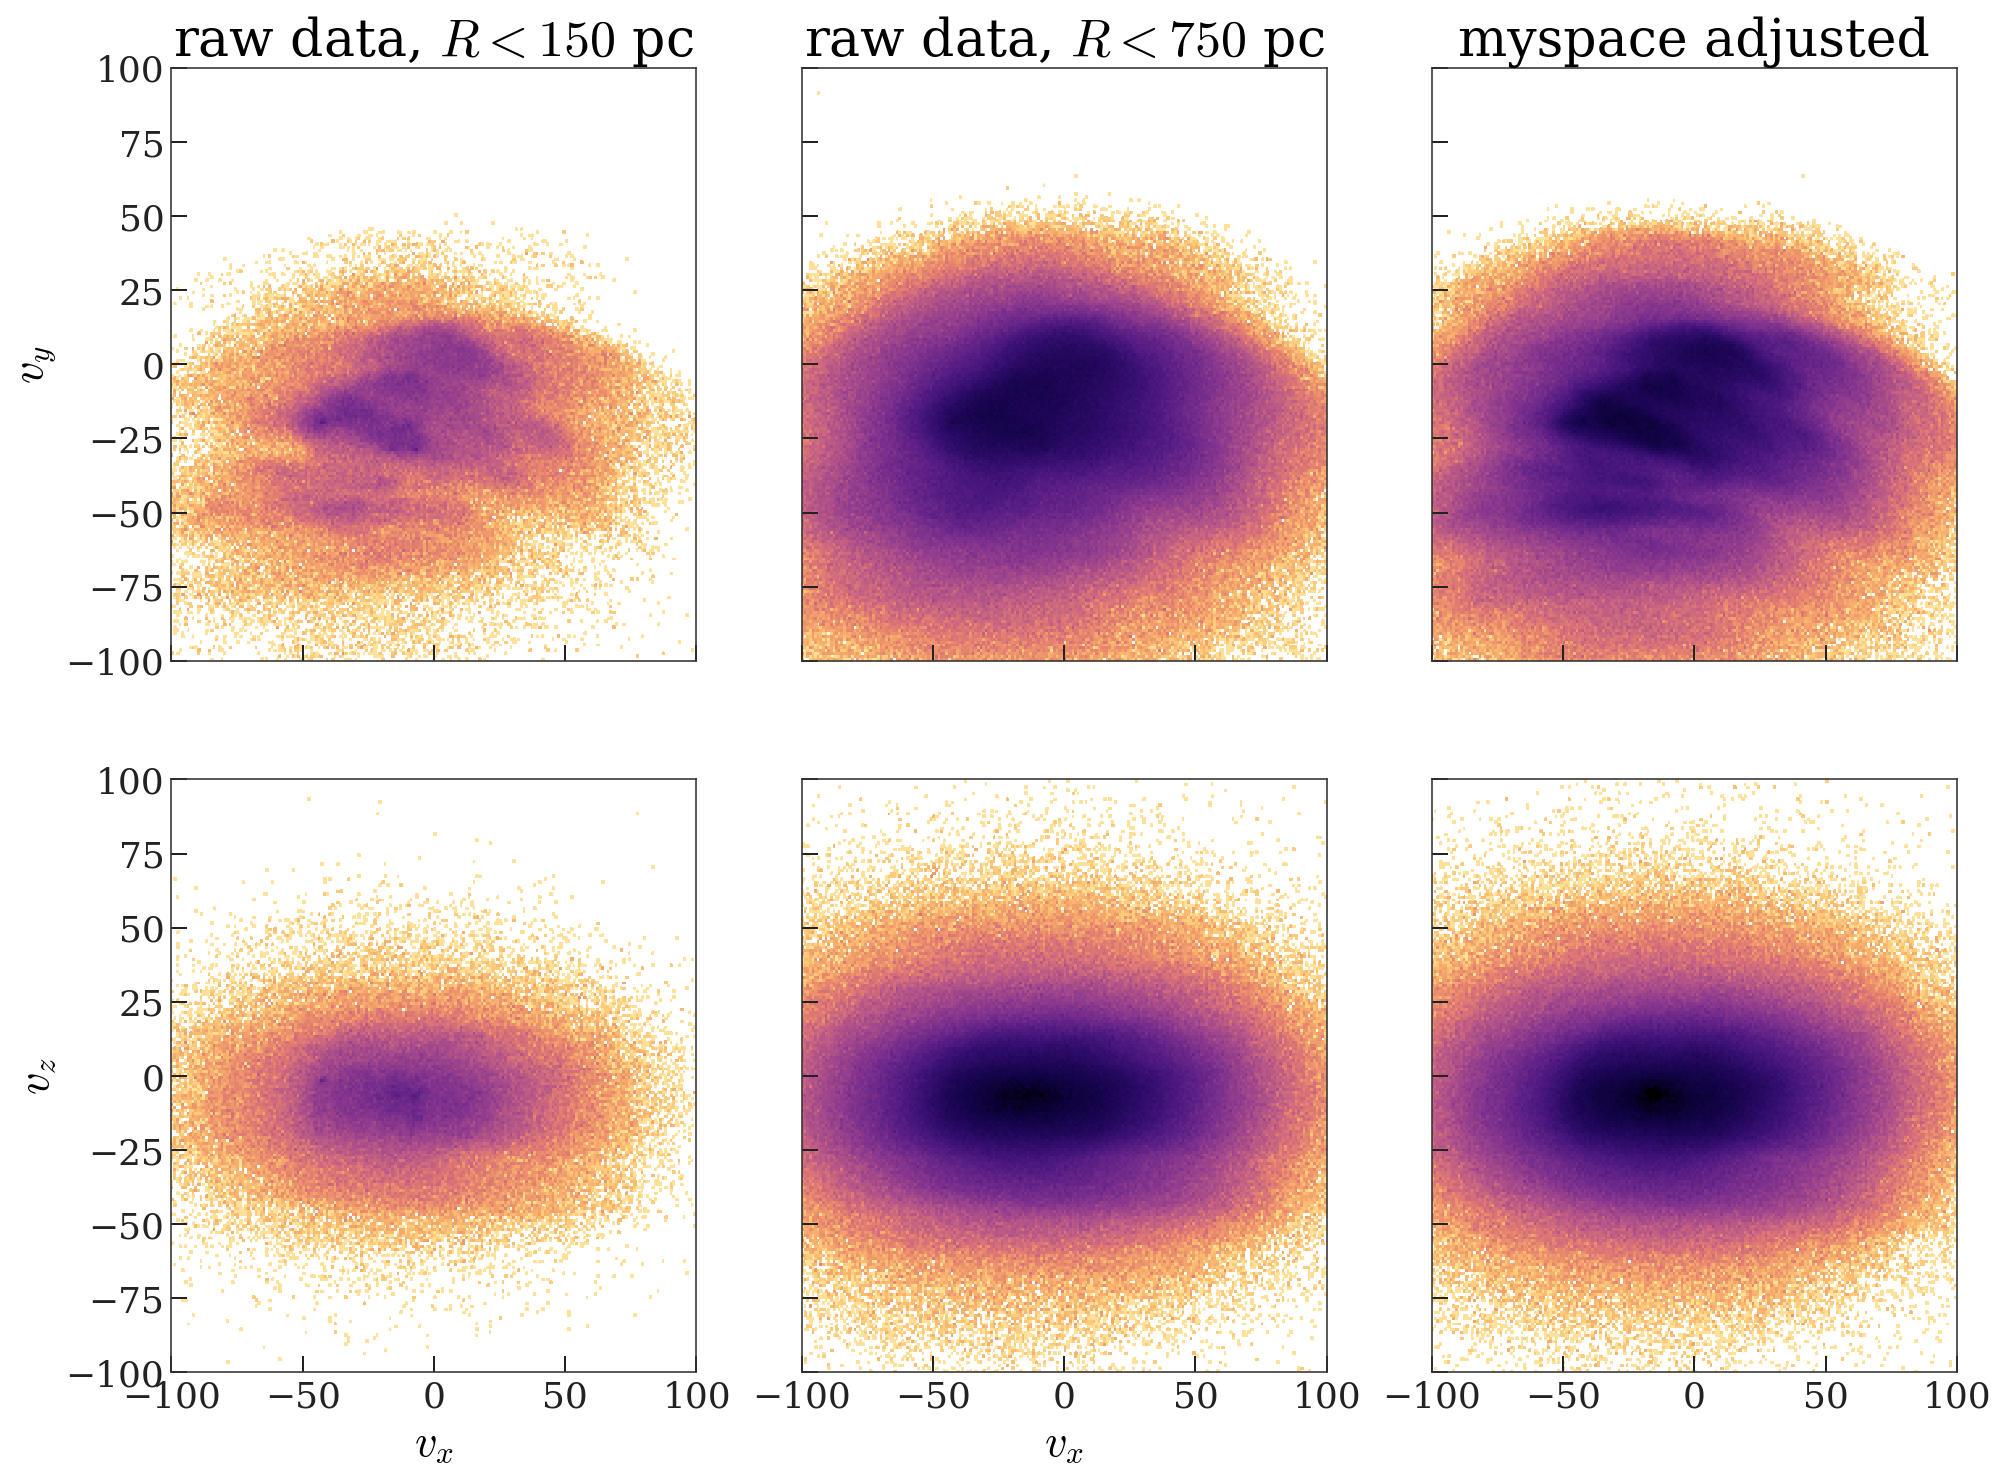

In [40]:
fig, all_axes = plt.subplots(2, 3, figsize=(16, 12),
                             sharex=True, sharey=True)

bins = np.arange(-100, 100+1e-3, 1)
style = dict(cmap='hesperia_r', norm=mpl.colors.LogNorm(1, 1e3))

axes = all_axes[0]

H, xe, ye = np.histogram2d(UVW[close_mask, 0], UVW[close_mask, 1],
                           bins=bins)
axes[0].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW[R_mask, 0], UVW[R_mask, 1],
                           bins=bins)
axes[1].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[R_mask, 0], UVW_fix[R_mask, 1],
                           bins=bins)
axes[2].pcolormesh(xe, ye, H.T, **style)

axes[0].set_title('raw data, $R < 150$ pc')
axes[1].set_title('raw data, $R < 750$ pc')
axes[2].set_title('myspace adjusted')

# axes[0].set_xlabel('$v_x$')
# axes[1].set_xlabel('$v_x$')
axes[0].set_ylabel('$v_y$')

axes = all_axes[1]
H, xe, ye = np.histogram2d(UVW[R_mask, 0], UVW[R_mask, 2],
                           bins=bins)
axes[1].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[R_mask, 0], UVW_fix[R_mask, 2],
                           bins=bins)
axes[2].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[close_mask, 0], UVW_fix[close_mask, 2],
                           bins=bins)
axes[0].pcolormesh(xe, ye, H.T, **style)

axes[0].set_xlabel('$v_x$')
axes[1].set_xlabel('$v_x$')
axes[0].set_ylabel('$v_z$')

fig.savefig('raw-vs-myspace-750.png', dpi=250)